# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Explore

### portfolio

In [19]:
portfolio
# 10 types of offers in total 

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### profile

In [20]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [3]:
# id is unique identifier
profile.id.nunique() == profile.shape[0]

True

In [4]:
# notice missing values in gender and income
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [5]:
profile.gender.isnull().sum() / profile.shape[0]

0.12794117647058822

In [25]:
profile.gender.isnull().sum()

2175

In [6]:
profile[profile.gender.isnull()]['income'].isnull().sum()
# missing gender and income occur on same rows

2175

In [7]:
profile[profile.gender.isnull()].head()
# the numbers doesn't look right, age 118
# could check if they've made any transaction, if not, can safely remove them

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


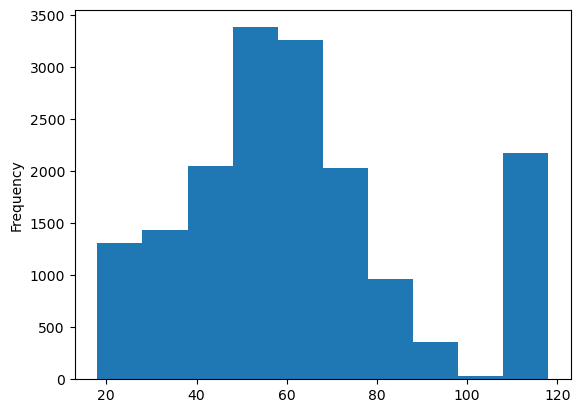

In [9]:
profile.age.plot(kind='hist');

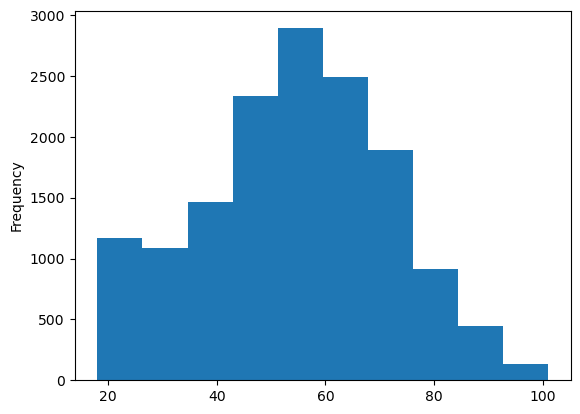

In [10]:
# age 118 noises all come from gender null rows
profile[profile.gender.notnull()].age.plot(kind='hist');

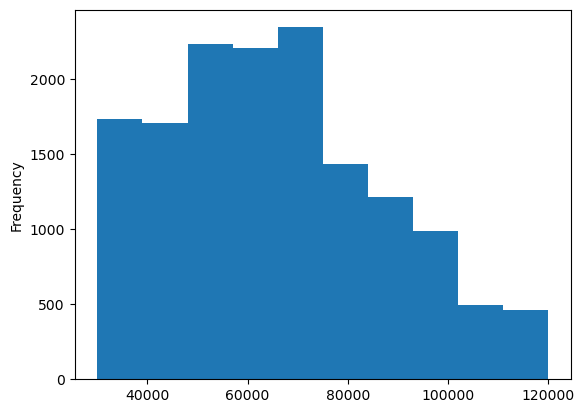

In [11]:
profile.income.plot(kind='hist');

In [378]:
# became member on could be convert to date column
profile['became_member_on_dt'] = pd.to_datetime(profile.became_member_on, format="%Y%m%d")

In [394]:
def clean_profile(df):
    '''Clean profile data'''
    df = df[df['age'] != 118].copy() # drop noise rows
    df['became_member_on_dt'] = pd.to_datetime(df['became_member_on'], format="%Y%m%d")
    max_became_member_date = df['became_member_on_dt'].max()
    df['tenure_day'] = (max_became_member_date - df['became_member_on_dt']).dt.days
    df['tenure_month'] = df['tenure_day'] // 30
    df['tenure_year'] = df['tenure_day'] // 365
    df.drop(columns=['became_member_on', 'became_member_on_dt'], inplace=True)
    return df

In [395]:
clean_profile(profile)

,gender,age,id,income,tenure_day,tenure_month,tenure_year
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376,12,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,14,1
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91,3,0
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167,5,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,8,0
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,52,1,0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,13,0,0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,73000.0,546,18,1
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,871,29,2


In [13]:
profile['became_member_on_year'] = profile['became_member_on_dt'].dt.year

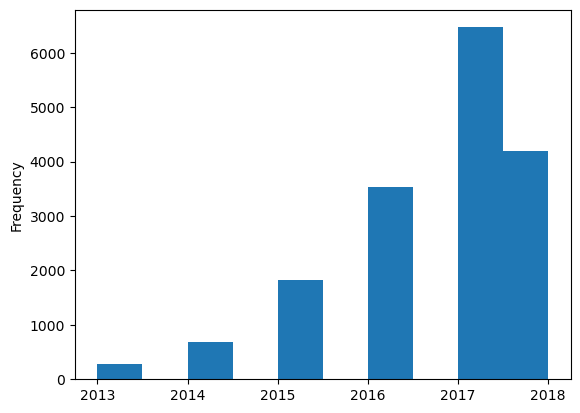

In [14]:
profile.became_member_on_year.plot(kind='hist');
# data up to 2018, customer tenure column potentially would be a good feature

In [377]:
profile[profile.gender.isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


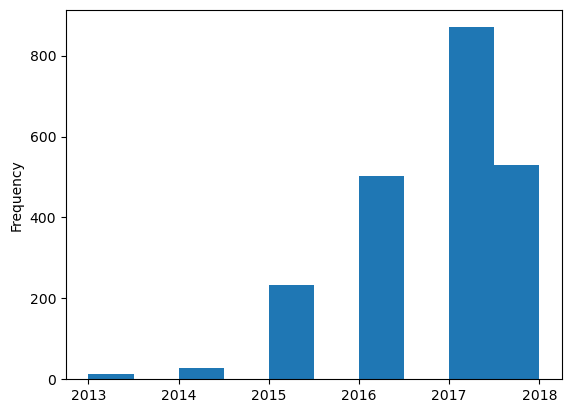

In [15]:
profile[profile.gender.isnull()]['became_member_on_year'].plot(kind='hist');
# no clear pattern for gender null values on became member year
# distribution is very similar to overall distribution above

In [404]:
for index, row in portfolio.iterrows():
    for channel in row['channels']:
        if channel not in portfolio.columns: # add new channel column
            portfolio[channel] = 0
        portfolio.at[index, channel] = 1

In [405]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### transcript

In [16]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [52]:
# no missing values

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [18]:
transcript.sample(10)

,person,event,value,time
241076,fc3405b8b39d40cb81af12db2c9064c3,transaction,{'amount': 18.32},558
268801,c754e0a81d6b4b66a7a4f8477f96f29a,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},588
198610,7a6ef9ad24324dbfaf780486ce829400,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,492
202761,9e3f177afd7a4d939d486f79e4bfeeb6,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504
26290,f682739f9c20422db355da9bde6b7668,transaction,{'amount': 17.54},36
100979,e8eef0c431cc4fa98381ed2043c843a4,transaction,{'amount': 24.71},276
77328,494a99f508f74ad0ae047c68bf837791,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},192
235888,8c54f6657313449b9f78e1f6b7a17aa9,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},546
82745,4018381562d645bca291b2ea87413258,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},204
173831,97b938182cbd48e2b02c859dc8e7838c,transaction,{'amount': 2.12},420


In [19]:
transcript[transcript.person == '4ad3748475204cf99571183f05b5e2f7']

,person,event,value,time
593,4ad3748475204cf99571183f05b5e2f7,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12781,4ad3748475204cf99571183f05b5e2f7,transaction,{'amount': 4.08},0
18171,4ad3748475204cf99571183f05b5e2f7,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},12
31167,4ad3748475204cf99571183f05b5e2f7,transaction,{'amount': 4.43},54
32676,4ad3748475204cf99571183f05b5e2f7,transaction,{'amount': 5.03},60
99020,4ad3748475204cf99571183f05b5e2f7,transaction,{'amount': 3.1},270
151210,4ad3748475204cf99571183f05b5e2f7,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408
185004,4ad3748475204cf99571183f05b5e2f7,transaction,{'amount': 8.6},450
185005,4ad3748475204cf99571183f05b5e2f7,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,450
202165,4ad3748475204cf99571183f05b5e2f7,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504


In [20]:
transcript.person.nunique()

17000

In [3]:
transcript['value_key'] = transcript.value.apply(lambda x: list(x.keys())[0])

In [232]:
def extract_first_value(dictionary):
    if isinstance(val, dict) and val:  # Check if 'val' is a non-empty dictionary
        return next(iter(val.values()))
    else:
        return None
    
def clean_transcript(df):
    df['value_key'] = df['value'].apply(lambda x: list(x.keys())[0])
    df['value_key'] = df['value_key'].str.replace(' ','_') # "offer_id" and "offer id"
    
    df['offer_id'] = df[df['value_key'] == 'offer_id']['value'].apply(extract_first_value)
    df['transaction_amount'] = df[df['value_key'] == 'amount']['value'].apply(extract_first_value)
    return df

In [230]:
clean_transcript(transcript)
transcript.sample(10)

,person,event,value,time,value_key,offer_id,transaction_amount,amount
88030,562b9efc809b4bd897ce0381347aaea2,transaction,{'amount': 17.0},222,amount,NaN,17.00,17.00
203993,591b17b5a24a44f7a23bd2296e46e0c4,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},504,offer_id,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
107279,10fb6eee170242c1b1ad9fc2299f5485,transaction,{'amount': 2.7800000000000002},312,amount,NaN,2.78,2.78
50684,c89988070f2a4f95b5844f2581256e56,transaction,{'amount': 15.8},150,amount,NaN,15.80,15.80
295085,e907946cc01e4e11b814b1ab946755a0,transaction,{'amount': 1.94},666,amount,NaN,1.94,1.94
94545,4861f8f83a6145e3aa9c7a08cf1eff00,transaction,{'amount': 1.12},246,amount,NaN,1.12,1.12
191079,f13e0cdcf8bf42ba8fccfe1be4e6d133,transaction,{'amount': 5.52},462,amount,NaN,5.52,5.52
180470,db7f39b7c3174c71b45dd73f35b2be72,transaction,{'amount': 37.33},438,amount,NaN,37.33,37.33
268017,b93935163cfb40399e6c1a3760b64f6d,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,588,offer_id,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN
294269,61047f86ce9c4dd79951d46a021d6904,transaction,{'amount': 25.49},660,amount,NaN,25.49,25.49


In [6]:
transcript['offer_id'] = transcript['value'].apply(extract_offer_id)

In [7]:
transcript['transaction_amount'] = transcript['value'].apply(lambda x: x['amount'] if 'amount' in x.keys() else None)

In [11]:
transcript_merge = transcript.merge(portfolio[['id', 'offer_type','difficulty','duration']], 
                                     left_on='offer_id', right_on='id', how='left')

In [35]:
transcript_merge[transcript_merge.person == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time,value_key,offer_id,transaction_amount,id,offer_type,difficulty,duration
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,amount,None,19.89,NaN,NaN,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,amount,None,17.78,NaN,NaN,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,offer id,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,offer id,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,amount,None,19.67,NaN,NaN,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,amount,None,29.72,NaN,NaN,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,amount,None,23.93,NaN,NaN,NaN,NaN


### How to clean transcript data, customer responded to an offer

1. non-informational offers, as long as it has offer_viewed AND offer_completed events, and offer_complete <b>>=</b> offer_viewed
2. informational offers, customer made purchases during influenced period, without other non-informational offer's influence
3. No offer, customer made purchase outside offer influence period of any offer type

### New approach
For each customer, iterate through transactions, order by time:
- maintain a priority queue, order by offer_impact_end_time, called offer_pq
- if "offer viewed", generate new record, push new element to offer_pq
- if "offer completed", save offer_complete_time to closest record, with same offer_id and no completion time. Also pop out related element from offer_pq
- maintain each offer's impact period, from offer_viewed to min(offer_completed, offer_viewed + duration)
- if "transaction", pop out expired offers from offer_pq.
    - if both non-informational and informational offers are in offer_stack, map it to non-informational offer
    - if offer_stack is empty map it to "No Offer"

#### Data Callouts
1. One person can receive same offer multiple times, so [customer_id + offer_id + offer_receive_time] is unique key

In [69]:
import heapq

In [168]:
transcript_merge.sample(5)

,person,event,value,time,value_key,offer_id,transaction_amount,id,offer_type,difficulty,duration
173588,8aef76b765204f9ab1b63d601dd8be63,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},420,offer id,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,discount,10.0,7.0
302158,361da3e85e3f447cb8239a4ca6852f6e,transaction,{'amount': 27.85},696,amount,None,27.85,NaN,NaN,NaN,NaN
235126,cdf10567189a4308bc8dabd95ff6d48c,transaction,{'amount': 9.43},540,amount,None,9.43,NaN,NaN,NaN,NaN
196790,56a3ee101c3b45cdaae583bc4097197a,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,480,offer_id,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7.0,7.0
62990,d7f94cafc2e5434d9d12cd5da0bf5fa1,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},168,offer id,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0


In [180]:
test_df = transcript_merge[transcript_merge.person.isin(['8aef76b765204f9ab1b63d601dd8be63',
                                                        '361da3e85e3f447cb8239a4ca6852f6e',
                                                        'cdf10567189a4308bc8dabd95ff6d48c'])].copy()
test_df

,person,event,value,time,value_key,offer_id,transaction_amount,id,offer_type,difficulty,duration
2264,361da3e85e3f447cb8239a4ca6852f6e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,offer id,ae264e3637204a6fb9bb56bc8210ddfd,NaN,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,7.0
8656,cdf10567189a4308bc8dabd95ff6d48c,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,offer id,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,informational,0.0,4.0
9431,8aef76b765204f9ab1b63d601dd8be63,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,offer id,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0
39761,361da3e85e3f447cb8239a4ca6852f6e,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},90,offer id,ae264e3637204a6fb9bb56bc8210ddfd,NaN,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,7.0
45177,8aef76b765204f9ab1b63d601dd8be63,transaction,{'amount': 10.26},114,amount,None,10.26,NaN,NaN,NaN,NaN
62638,8aef76b765204f9ab1b63d601dd8be63,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},168,offer id,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0
74153,8aef76b765204f9ab1b63d601dd8be63,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},180,offer id,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0
97659,cdf10567189a4308bc8dabd95ff6d48c,transaction,{'amount': 3.21},258,amount,None,3.21,NaN,NaN,NaN,NaN
104594,8aef76b765204f9ab1b63d601dd8be63,transaction,{'amount': 17.7},294,amount,None,17.70,NaN,NaN,NaN,NaN
104595,8aef76b765204f9ab1b63d601dd8be63,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,294,offer_id,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0


In [181]:
customer_offer_data = pd.DataFrame(columns=["customer", "offer_id", "offer_type", "offer_receive_time",
                                            "offer_view_time", "offer_complete_time", "offer_respond"])

offer_pq = []

for index, row in test_df.iterrows():
    customer = row["person"]
    event = row["event"]
    offer_id = row["offer_id"]
    offer_type = row["offer_type"]
    time = row["time"]
    duration = row["duration"]
    
    if event == "offer received":
        new_record = pd.DataFrame([{"customer": customer, 
                                    "offer_id": offer_id, 
                                    "offer_type": offer_type,
                                    "offer_receive_time": time,
                                    "offer_view_time": None, 
                                    "offer_complete_time": None}])
        customer_offer_data = pd.concat([customer_offer_data, new_record], axis=0, ignore_index=True)
        
    if event == "offer viewed":
        # Find the corresponding offer received row and update its completion time
        viewed_row = customer_offer_data[(customer_offer_data["customer"] == customer) &
                                           (customer_offer_data["offer_id"] == offer_id) &
                                           (customer_offer_data["offer_view_time"].isna())]
        if not viewed_row.empty:
            viewed_row_index = viewed_row.index[-1] # select most recent row to update
            customer_offer_data.at[viewed_row_index, "offer_view_time"] = time
        
        # push offer with its impact end time, offer type, and view_time
        heapq.heappush(offer_pq, [time + duration * 24, offer_id, offer_type, time])
        
    elif event == "offer completed":
        # pop out from pq
        offer_pq = [offer for offer in offer_pq if offer[1] != offer_id]
        
        # Find the corresponding offer received row and update its completion time
        received_row = customer_offer_data[(customer_offer_data["customer"] == customer) &
                                           (customer_offer_data["offer_id"] == offer_id) &
                                           (customer_offer_data["offer_complete_time"].isna())]
        if not received_row.empty:
            received_row_index = received_row.index[-1] # select most recent row to update
            customer_offer_data.at[received_row_index, "offer_complete_time"] = time
            
    elif event == "transaction":
        # pop out expired offers
        while offer_pq and offer_pq[0][0] < time:
            heapq.heappop(offer_pq)
        
        # locate impact_offer_id, and generate impact informational offer set
        impact_offer_id = None
        impact_informational_offers = []
        has_non_informational_offer = False
        
        for offer in offer_pq:
            impact_offer_id = offer[1]
            if offer[2] == 'informational':
                impact_informational_offers.append(offer)
            else:
                has_non_informational_offer = True
                break
                
        # record respond to informational offers
        if not has_non_informational_offer:
            for info_offer in impact_informational_offers:
                impact_row = customer_offer_data[(customer_offer_data['customer'] == customer) &
                                       (customer_offer_data['offer_id'] == info_offer[1]) &
                                       (customer_offer_data['offer_view_time'] == info_offer[3])]
                customer_offer_data.at[impact_row.index[0], "offer_respond"] = 1
                
        # record impact offer_id
        if impact_offer_id:
            test_df.at[index, 'impact_offer_id'] = impact_offer_id

            
def fill_offer_respond(row):
    '''Fill offer_respond column base on conditions'''    
    if row['offer_respond'] == 1 or (
        row["offer_type"] != "informational" and
        row["offer_complete_time"] is not None and
        row["offer_view_time"] is not None and
        row["offer_complete_time"] >= row["offer_view_time"]
    ):
        return 1
    else:
        return 0

customer_offer_data['offer_respond'] = customer_offer_data.apply(fill_offer_respond, axis=1)

In [187]:
customer_offer_data[customer_offer_data['customer'] == 'cdf10567189a4308bc8dabd95ff6d48c']

,customer,offer_id,offer_type,offer_receive_time,offer_view_time,offer_complete_time,offer_respond
1,cdf10567189a4308bc8dabd95ff6d48c,3f207df678b143eea3cee63160fa8bed,informational,0,None,None,0
7,cdf10567189a4308bc8dabd95ff6d48c,5a8bc65990b245e5a138643cd4eb9837,informational,408,408,None,0
10,cdf10567189a4308bc8dabd95ff6d48c,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,504,504,540,1


In [192]:
test_df[(test_df.event == 'transaction') & 
        (test_df.impact_offer_id.isna())].groupby('person').agg({'transaction_amount':'sum',
                                                                'event':'count'})

,transaction_amount,event
person,,
361da3e85e3f447cb8239a4ca6852f6e,59.3,2


In [36]:
test_data = transcript_merge[transcript_merge.person == '75a147f153b74a3c9168b657a901aa3c'].copy()

In [37]:
test_data['offer_view_time'] = test_data['time'].where(test_data['event'] == 'offer viewed')
test_data['offer_complete_time'] = test_data['time'].where(test_data['event'] == 'offer completed')

In [45]:
test_offers = test_data.groupby(['offer_id', 'offer_type','offer_view_time', 'offer_complete_time'],
                               dropna=False)['duration'].max().reset_index()
test_offers

,offer_id,offer_type,offer_view_time,offer_complete_time,duration
0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,576.0,NaN,7.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,NaN,600.0,7.0
2,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,NaN,NaN,7.0
3,5a8bc65990b245e5a138643cd4eb9837,informational,354.0,NaN,3.0
4,5a8bc65990b245e5a138643cd4eb9837,informational,414.0,NaN,3.0
5,5a8bc65990b245e5a138643cd4eb9837,informational,NaN,NaN,3.0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,NaN,NaN,7.0
7,fafdcd668e3743c1bb461111dcafc2a4,discount,234.0,NaN,10.0
8,fafdcd668e3743c1bb461111dcafc2a4,discount,NaN,276.0,10.0
9,fafdcd668e3743c1bb461111dcafc2a4,discount,NaN,NaN,10.0


In [41]:
test_offers

,offer_id,offer_type,offer_view_time,offer_complete_time,duration,impact_end_time
0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,576.0,NaN,7.0,744.0
1,5a8bc65990b245e5a138643cd4eb9837,informational,354.0,NaN,3.0,426.0
2,5a8bc65990b245e5a138643cd4eb9837,informational,414.0,NaN,3.0,486.0
3,fafdcd668e3743c1bb461111dcafc2a4,discount,234.0,NaN,10.0,474.0


In [26]:
test_data.merge(test_offers[['offer_id', 'impact_end_time']], on='offer_id', how='left')

,person,event,value,time,value_key,offer_id,transaction_amount,id,offer_type,difficulty,duration,offer_view_time,offer_complete_time,impact_end_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0,NaN,NaN,132.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0,6.0,NaN,132.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,amount,None,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0,NaN,132.0,132.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,amount,None,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,offer id,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0,NaN,NaN,288.0
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,offer id,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,3.0,216.0,NaN,288.0
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,amount,None,19.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,amount,None,29.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,amount,None,23.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
test_data[test_data.value_key == 'amount'].groupby

,person,event,value,time,value_key,offer_id,transaction_amount,id,offer_type,difficulty,duration,offer_view_time,offer_complete_time
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,amount,None,19.89,NaN,NaN,NaN,NaN,NaN,NaN
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,amount,None,17.78,NaN,NaN,NaN,NaN,NaN,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,amount,None,19.67,NaN,NaN,NaN,NaN,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,amount,None,29.72,NaN,NaN,NaN,NaN,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,amount,None,23.93,NaN,NaN,NaN,NaN,NaN,NaN
218393,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 21.72},510,amount,None,21.72,NaN,NaN,NaN,NaN,NaN,NaN
230412,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 26.56},534,amount,None,26.56,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
cd data

/Users/yuxiangqin/Learning/Udacity_Data_Scientist_Nanodegree/Starbucks-Capstone-Challenge/data


In [241]:
%run process_data.py

Loading data
Cleaning data
Generating customer respond
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/yuxiangqin/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2866, in safe_execfile
    py3compat.execfile(
  File "/Users/yuxiangqin/anaconda3/lib/python3.10/site-packages/IPython/utils/py3compat.py", line 55, in execfile
    exec(compiler(f.read(), fname, "exec"), glob, loc)
  File "/Users/yuxiangqin/Learning/Udacity_Data_Scientist_Nanodegree/Starbucks-Capstone-Challenge/data/process_data.py", line 184, in <module>
    main()
  File "/Users/yuxiangqin/Learning/Udacity_Data_Scientist_Nanodegree/Starbucks-Capstone-Challenge/data/process_data.py", line 178, in main
    customer_offer_data = get_customer_respond(merged)
  File "/Users/yuxiangqin/Learning/Udacity_Data_Scientist_Nanodegree/Starbucks-Capstone-Challenge/data/process_data.py", line 149, in get_customer_respond
    add_informational_respond(customer_offer_data, customer, impact_informational_offers)
  File "/Users/yuxiangqin/Learning/Udacity_Data_Sc

In [245]:
portfolio, profile, transcript = load_data('portfolio.json',
                                            'profile.json',
                                            'transcript.json')
clean_transcript(transcript)
merged = transcript.merge(portfolio[['id', 'offer_type','difficulty','duration']],
                                 left_on='offer_id', right_on='id', how='left')

In [320]:
def get_customer_no_offer_impact_transaction(df):
    '''Returns customer level transaction info without any offer impact'''
    no_offer = df[(df['value_key'] == 'amount') & (df['impact_offer_id'].isna())]
    no_offer = no_offer.groupby('person').agg({'transaction_amount':'sum',
                                                'event': 'count'}).reset_index()
    no_offer['with_offer'] = 0                                
    with_offer = df[(df['value_key'] == 'amount') & (df['impact_offer_id'].notna())]
    with_offer = with_offer.groupby('person').agg({'transaction_amount':'sum',
                                                'event': 'count'}).reset_index()
    with_offer['with_offer'] = 1
    res = pd.concat([no_offer, with_offer], axis=0)
    res.rename(columns={'event': 'transaction_count'}, inplace=True)
    
    return res

In [321]:
no_offer_transactions = get_customer_no_offer_impact_transaction(merged)

In [322]:
df = no_offer_transactions.merge(profile, left_on='person', right_on='id', how='left')

In [323]:
df = df[df.age != 118]

In [325]:
import plotly.express as px

In [350]:
def get_by_demo_data(df, demograph_nm):
    demo_data = df.groupby([demograph_nm, 'with_offer']).agg({
        'transaction_amount': 'sum',
        'transaction_count': ['sum', 'mean']
    }).reset_index()
    demo_data.columns = [demograph_nm, 'with_offer', 'sum_transaction_amount', 'sum_transaction_count', 'avg_transaction_count']
    demo_data['avg_amount'] = demo_data['sum_transaction_amount'] / demo_data['sum_transaction_count']
    demo_data['with_offer'] = demo_data['with_offer'].astype('category')
    return demo_data

In [351]:
age_data = get_by_demo_data(df, 'age')
income_data = get_by_demo_data(df, 'income')
gender_data = get_by_demo_data(df, 'gender')

In [344]:
px.scatter(age_data, x='age', y='avg_transaction_count', 
           color='with_offer', 
           category_orders={'with_offer': [0, 1]})

In [345]:
px.scatter(age_data, x='age', y='avg_amount', 
           color='with_offer', 
           category_orders={'with_offer': [0, 1]})

In [374]:
px.bar(gender_data, x='gender', 
       y='avg_transaction_count', 
       color='with_offer', 
       barmode='group')

In [375]:
px.bar(gender_data, x='gender', 
       y='sum_transaction_amount', 
       color='with_offer', 
       barmode='group')

In [372]:
px.scatter(income_data, x='income', y='avg_transaction_count', 
           color='with_offer')

In [373]:
px.scatter(income_data, x='income', y='avg_amount', 
           color='with_offer')

/var/folders/w_/dbbjmm190gd_d9j5gvdbc_zr0000gn/T/ipykernel_92040/1232612408.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[df.age < 118].corr(), annot=True)


<Axes: >

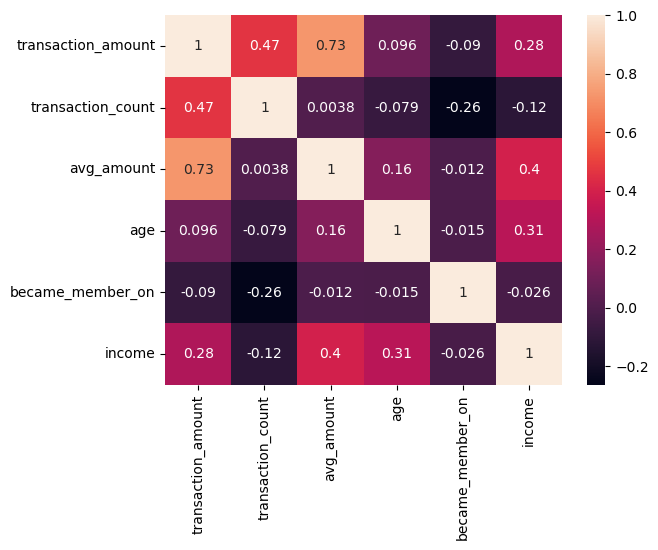

In [306]:
import seaborn as sns
sns.heatmap(df[df.age < 118].corr(), annot=True)

<Axes: xlabel='gender', ylabel='transaction_count'>

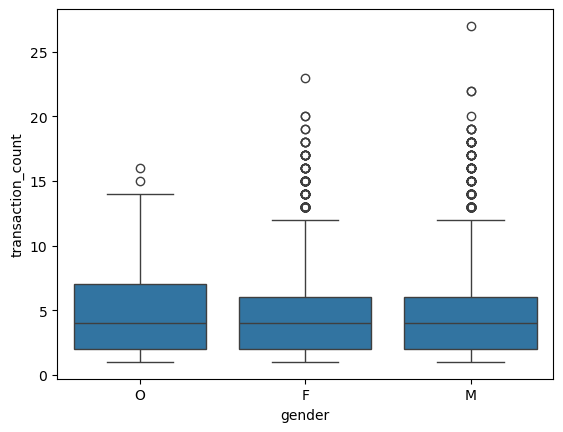

In [313]:
sns.boxplot(df, x='gender', y='transaction_count')

In [407]:
run process_data.py

Loading data
Cleaning data
Generating customer respond
Saving data


In [ ]:
database_filepath = ''

def load_data(database_filepath):
    '''Load data from input filepath and return X, Y and category_names'''
    engine = create_engine(f'sqlite:///{database_filepath}')
    df = pd.read_sql_table('data', engine.connect())
    df.dropna(subset=['related'], inplace=True)
    X = df['message']
    Y = df.iloc[:,-36:]
    return X, Y, Y.columns

In [419]:
database_filepath = 'data/customer_offer_data.db'
engine = create_engine(f'sqlite:///{database_filepath}')
df = pd.read_sql_table('data', engine.connect())

In [421]:
df.drop(columns=['customer_id','offer_id','offer_receive_time','offer_view_time','offer_complete_time'], inplace=True)

In [444]:
Y = df['offer_respond']
X = df.iloc[:, 1:]
dummy_cols = ['gender', 'offer_type']
for dummy_col in dummy_cols:
    X = pd.concat([X, pd.get_dummies(X[dummy_col], prefix=dummy_col)], axis=1)
    X.drop(columns=[dummy_col], inplace=True)
X.columns = X.columns.astype(str)

In [474]:
X.drop(columns=['tenure_month', 'tenure_year'], inplace=True)

In [475]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have X, y data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessing step
    ('classifier', RandomForestClassifier())  # Example model
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
f1_score = f1_score(y_test, y_pred)
print(f'F1 Score: {f1_score:.2f}')
importances = pipeline.named_steps['classifier'].feature_importances_

Accuracy: 0.67
F1 Score: 0.59


In [476]:
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

In [478]:
# overfitting
accuracy_score(y_train, pipeline.predict(X_train))

0.9567857142857142

In [488]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15],
    'classifier__max_features': ["sqrt", "log2", None]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model and its performance
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the results
print(f"Best parameters: {best_params}")
print(f"Best Accuracy Score: {best_score}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Best Accuracy Score: 0.6971804511278196


In [489]:
accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))

0.6930305992030674

In [477]:
feature_importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
2,tenure_day,0.384131
1,income,0.254951
0,age,0.247198
8,social,0.038416
5,duration,0.013219
4,difficulty,0.011761
3,reward,0.011699
7,mobile,0.009205
14,offer_type_discount,0.006963
11,gender_M,0.006274


In [491]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have X, y data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and XGBoost classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessing step
    ('classifier', XGBClassifier())  # XGBoost classifier
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.70
F1 Score: 0.61
[CV] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__n_estimators=100; total time=   2.7s
[CV] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__n_estimators=300; total time=   8.7s
[CV] END classifier__max_depth=5, classifier__max_features=log2, classifier__n_estimators=200; total time=   6.0s
[CV] END classifier__max_depth=5, classifier__max_features=None, classifier__n_estimators=100; total time=   7.0s
[CV] END classifier__max_depth=5, classifier__max_features=None, classifier__n_estimators=200; total time=  14.4s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100; total time=   5.4s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100; total time=   4.8s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=200; total time=   9.7s
[CV] END classifier__max_depth=10, classifier__max_feat

[CV] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__n_estimators=200; total time=   5.4s
[CV] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__n_estimators=300; total time=   8.9s
[CV] END classifier__max_depth=5, classifier__max_features=log2, classifier__n_estimators=300; total time=   8.6s
[CV] END classifier__max_depth=5, classifier__max_features=None, classifier__n_estimators=100; total time=   7.2s
[CV] END classifier__max_depth=5, classifier__max_features=None, classifier__n_estimators=300; total time=  21.9s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=200; total time=   9.5s
[CV] END classifier__max_depth=10, classifier__max_features=log2, classifier__n_estimators=100; total time=   5.1s
[CV] END classifier__max_depth=10, classifier__max_features=log2, classifier__n_estimators=200; total time=   9.8s
[CV] END classifier__max_depth=10, classifier__max_features=log2, classifier__n_estim

In [492]:
accuracy_score(y_train, pipeline.predict(X_train))

0.7511654135338346

In [495]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# Assuming you have X, y data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Preprocess the data - scaling is often important for SVMs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0)  # You can choose different kernels and C values

# Fit the classifier on the training data
svm_classifier.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.68
F1 Score: 0.57


In [496]:
X.head(5).to_clipboard()

In [456]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
# Assuming you have X, y data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessing step
    ('classifier', LogisticRegression())  # Example model
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.65
F1 Score: 0.54


In [498]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

def train_and_evaluate_models(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocess the data - scaling is often important for some models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Logistic Regression
    lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    lr_model = LogisticRegression()
    lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
    lr_grid_search.fit(X_train_scaled, y_train)

    # Random Forest
    rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    rf_model = RandomForestClassifier()
    rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
    rf_grid_search.fit(X_train_scaled, y_train)

    # XGBoost
    xgb_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}
    xgb_model = XGBClassifier()
    xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
    xgb_grid_search.fit(X_train_scaled, y_train)

    # Evaluate models
    models = {
        'Logistic Regression': lr_grid_search.best_estimator_,
        'Random Forest': rf_grid_search.best_estimator_,
        'XGBoost': xgb_grid_search.best_estimator_
    }

    for name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        print(f'\n{name} Results:')
        print(f'Accuracy: {accuracy:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'ROC-AUC Score: {roc_auc:.2f}')

    # Return the best model based on f1-score
    best_model_name = max(models, key=lambda k: f1_score(y_test, models[k].predict(X_test_scaled)))
    return models[best_model_name]

# Assuming you have X, y data
best_model = train_and_evaluate_models(X, Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Logistic Regression Results:
Accuracy: 0.65
F1 Score: 0.54
ROC-AUC Score: 0.63

Random Forest Results:
Accuracy: 0.69
F1 Score: 0.61
ROC-AUC Score: 0.67

XGBoost Results:
Accuracy: 0.70
F1 Score: 0.62
ROC-AUC Score: 0.69


In [504]:
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
feature_importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
8,social,0.402787
14,offer_type_discount,0.202124
11,gender_M,0.081568
3,reward,0.049207
2,tenure_day,0.049134
4,difficulty,0.034320
1,income,0.034131
12,gender_O,0.033720
0,age,0.025739
9,web,0.024455


In [529]:
df.groupby('gender').offer_respond.mean()

gender
F    0.464634
M    0.386845
O    0.528384
Name: offer_respond, dtype: float64

<Axes: xlabel='age'>

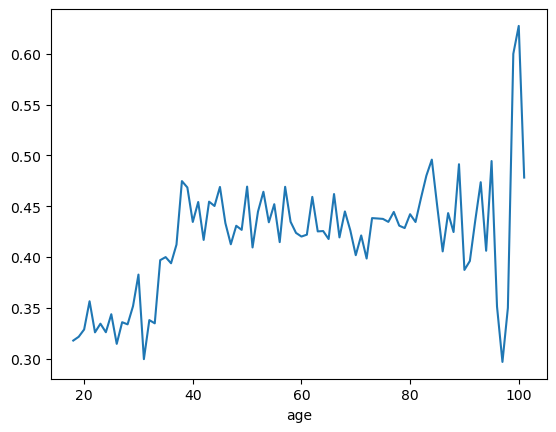

In [528]:
df.groupby('age').offer_respond.mean().plot()

In [524]:
df.groupby('tenure_month').offer_respond.mean().head(20)

tenure_month
0     0.255484
1     0.260830
2     0.241588
3     0.261699
4     0.261552
5     0.261678
6     0.335828
7     0.365959
8     0.353202
9     0.341286
10    0.362112
11    0.359765
12    0.457482
13    0.570458
14    0.540488
15    0.546419
16    0.545547
17    0.553136
18    0.553252
19    0.548295
Name: offer_respond, dtype: float64

<Axes: xlabel='tenure_month'>

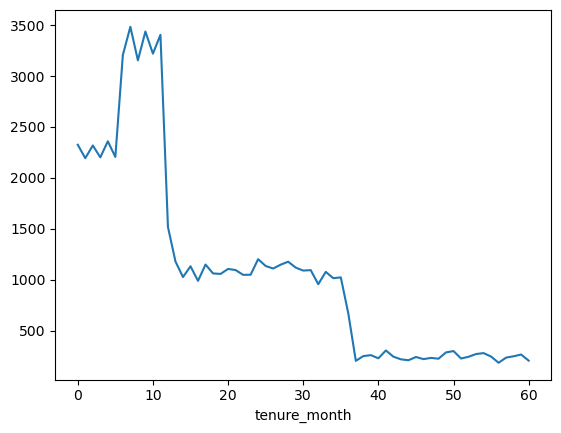

In [522]:
df.groupby('tenure_month').offer_respond.count().plot()